In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement sécurisé avec le chemin relatif vers le dossier data
try:
    df = pd.read_csv('../data/bank-full.csv', sep=';')
    print(f"Succès ! Le dataset contient {df.shape[0]} lignes et {df.shape[1]} colonnes.")
except FileNotFoundError:
    print("Erreur : Le fichier 'bank-full.csv' est introuvable dans le dossier 'data'.")

# Affichage des 5 premières lignes pour vérifier la structure
df.head()

Succès ! Le dataset contient 45211 lignes et 17 colonnes.


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
from sklearn.preprocessing import LabelEncoder

# 1. Vérification des données manquantes
print("Valeurs manquantes par colonne :\n", df.isnull().sum())

# 2. Encodage des variables textuelles
# On identifie automatiquement les colonnes de type 'object' (texte)
le = LabelEncoder()
categorical_columns = df.select_dtypes(include=['object']).columns

print("\nColonnes à encoder :", list(categorical_columns))

# Application de l'encodage
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

# 3. Vérification du résultat
print("\nAperçu après encodage (toutes les valeurs doivent être numériques) :")
print(df.head())

Valeurs manquantes par colonne :
 age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Colonnes à encoder : ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

Aperçu après encodage (toutes les valeurs doivent être numériques) :
   age  job  marital  education  default  balance  housing  loan  contact  \
0   58    4        1          2        0     2143        1     0        2   
1   44    9        2          1        0       29        1     0        2   
2   33    2        1          1        0        2        1     1        2   
3   47    1        1          3        0     1506        1     0        2   
4   33   11        2          3        0        1        0     0        2   

   day  month  duration  campaign  pdays  pr

In [7]:
from sklearn.model_selection import train_test_split

# 1. Définir X (caractéristiques) et y (cible)
X = df.drop('y', axis=1)
y = df['y']

# 2. Séparation 80% pour l'entraînement et 20% pour le test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Indispensable pour les classes déséquilibrées
)

print(f"Entraînement : {X_train.shape[0]} lignes")
print(f"Test : {X_test.shape[0]} lignes")

Entraînement : 36168 lignes
Test : 9043 lignes


In [8]:
from sklearn.ensemble import RandomForestClassifier
import joblib

# 1. Création du modèle
# On limite un peu la profondeur (max_depth) pour éviter que le modèle n'apprenne "par cœur" (overfitting)
model_bank = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)

# 2. Apprentissage
print("Entraînement en cours...")
model_bank.fit(X_train, y_train)

# 3. Sauvegarde du modèle final
joblib.dump(model_bank, 'bank_marketing.pkl')
print("Modèle entraîné et sauvegardé sous le nom 'bank_marketing.pkl'")

Entraînement en cours...
Modèle entraîné et sauvegardé sous le nom 'bank_marketing.pkl'


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# 1. On définit les modèles à tester
models = {
    "Arbre de Décision": DecisionTreeClassifier(max_depth=10, random_state=42),
    "Régression Logistique": LogisticRegression(max_iter=1000),
    "Random Forest (Notre choix)": model_bank # Déjà entraîné plus haut
}

results = []

# 2. On entraîne les nouveaux modèles et on compare
for name, model in models.items():
    if name != "Random Forest (Notre choix)": # On ne ré-entraîne pas le RF
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    # On calcule l'Accuracy (précision globale) et le F1-Score (précision sur les 'yes')
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({"Modèle": name, "Accuracy": round(acc, 4), "F1-Score": round(f1, 4)})

# 3. Affichage du tableau comparatif
df_results = pd.DataFrame(results)
print(df_results)

c:\Users\daddy\anaconda3\envs\iris_env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                        Modèle  Accuracy  F1-Score
0            Arbre de Décision    0.8994    0.5295
1        Régression Logistique    0.8869    0.2841
2  Random Forest (Notre choix)    0.9050    0.4753


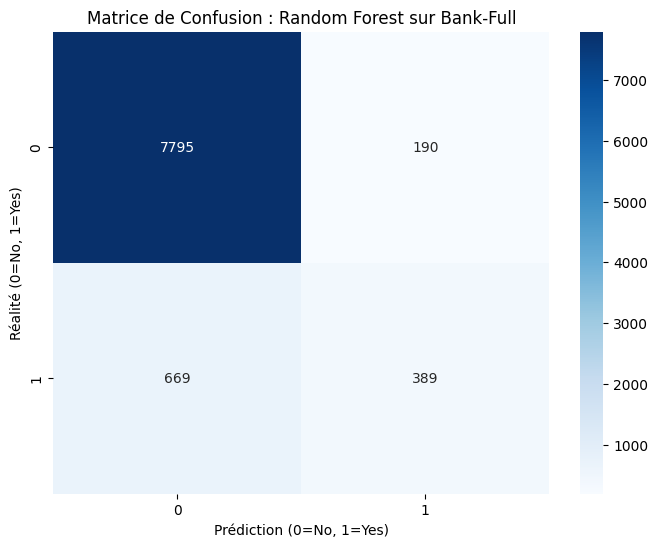

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# On utilise les prédictions du Random Forest
y_pred_final = model_bank.predict(X_test)
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion : Random Forest sur Bank-Full')
plt.ylabel('Réalité (0=No, 1=Yes)')
plt.xlabel('Prédiction (0=No, 1=Yes)')
plt.show()